In [2]:
import numpy as np
import pandas as pd
import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from joblib import dump, load
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import CIFAR10, GTSRB, MNIST, FashionMNIST, CIFAR100, ImageFolder, SVHN
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import clear_output

import torchbnn as bnn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

from methods_collection.utils.metrics_utils import auc_and_fpr_recall, acc

from methods_collection.odin.RuntimeMonitor import OdinMonitor
from networks import GtsrbAnnModel, ResNet18_32x32, Cifar10AnnModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = {}
config['resnet'] = {'temperature': 1000.0, 'noise': 0.002, 'threshold': 0.10094}
config['cifar10'] = {'temperature': 1000.0, 'noise': 0.001, 'threshold': 0.1055}
config['gtsrb'] = {'temperature': 1000.0, 'noise': 0.0016, 'threshold': 0.02367}

## Aux functions

In [4]:
class Convert:
    def __init__(self, mode='RGB'):
        self.mode = mode

    def __call__(self, image):
        return image.convert(self.mode)

In [5]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [6]:
def compute_all_metrics(result_in, result_out, odin_th):
  conf_in, pred_in, lab_in = result_in
  conf_out, pred_out, lab_out = result_out
  lab_out = -1 * np.ones_like(lab_out)

  conf = np.concatenate([conf_in, conf_out])
  y_pred = np.concatenate([pred_in, pred_out])
  y_true = np.concatenate([lab_in, lab_out])

  recall = 0.95
  auroc, aupr_in, aupr_out, fpr = auc_and_fpr_recall(conf, y_true, recall)

  accuracy = acc(y_pred, y_true)

  lab_true = np.zeros_like(y_true)
  lab_true[y_true == -1] = 1
  lab_pred = np.zeros_like(y_true)
  lab_pred[conf<=odin_th] = 1

  tn, fp, fn, tp = confusion_matrix(lab_true, lab_pred).ravel()
  results = [np.round(auroc*100, 2), np.round(fpr*100, 2), np.round(aupr_out*100, 2), tn, fp, fn, tp]
  return results

In [16]:
def evaluate_ood(model, ood_monitor, dataset_name, train=False):
  batch_size = 128
  dataset, test_dataset, transform = load_dataset(dataset_name)

  set_loader = DataLoader(dataset, batch_size, num_workers=2) if train else DataLoader(test_dataset, batch_size, num_workers=2)

  all_pred = []
  all_conf = []
  all_lab = []
  valCorrect = 0
  for data, target in set_loader:
        (x, y) = (data.to(device), target.to(device))
        x.requires_grad = True
        pred_values, conf = ood_monitor.process_input(model, x)

        valCorrect += torch.sum(pred_values == y).cpu()

        all_pred += pred_values.detach().cpu().numpy().tolist()
        all_conf += conf.detach().cpu().numpy().tolist()
        all_lab += y.detach().cpu().numpy().tolist()
  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  print(f'Accuracy: {np.round(valCorrect * 100 / len(set_loader.dataset), 6)}')

  return all_conf, all_pred, all_lab

In [8]:
def evaluate_ood_gaussian(model, ood_monitor, dataset_name, data_size=10000):
  dataset, test_dataset, transform = load_dataset(dataset_name)
  batch_size = 100
  num_batches = int(data_size/batch_size)

  all_conf = []
  all_pred = []
  all_lab = []
  for i in range(num_batches):
    np_images = np.asarray(np.uint8(np.random.rand(batch_size, 32, 32, 3) * 255))
    pil_images_tr = [transform(Image.fromarray(im, 'RGB')) for im in np_images]
    gaussian_noise = torch.stack(pil_images_tr).to(device)
    gaussian_noise.requires_grad = True
    pred_values, conf = ood_monitor.process_input(model, gaussian_noise)
    all_pred += pred_values.detach().cpu().numpy().tolist()
    all_conf += conf.detach().cpu().numpy().tolist()
    all_lab += -1 * np.ones(data_size).tolist()


  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  return all_conf, all_pred, all_lab

## Dataset loading

In [9]:
def load_dataset(DATASET_TO_USE):
  dataset = None
  test_dataset = None
  transform = transforms.Compose([
      Convert('RGB'),
      transforms.Resize([32, 32], interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
      ])
  if DATASET_TO_USE == 'CIFAR10':
    root_dataset_path = './datasets/cifar10/'
    dataset = CIFAR10(root=root_dataset_path, download=False, transform=transform)
    test_dataset = CIFAR10(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'GTSRB':
    root_dataset_path = './datasets/'
    dataset = GTSRB(root='./datasets/', download=False, split='train', transform=transform)
    test_dataset = GTSRB(root='./datasets/', download=False, split='test',transform=transform)
  if DATASET_TO_USE == 'MNIST':
    root_dataset_path = './datasets/mnist/'
    dataset = MNIST(root=root_dataset_path, download=False, transform=transform)
    test_dataset = MNIST(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'FashionMNIST':
    root_dataset_path = './datasets/fashion_mnist/'
    dataset = FashionMNIST(root=root_dataset_path, train=True, download=False, transform=transform)
    test_dataset = FashionMNIST(root=root_dataset_path, train=False, download=False, transform=transform)
  if DATASET_TO_USE == 'CIFAR100':
    root_dataset_path = './datasets/cifar100/'
    dataset = CIFAR100(root=root_dataset_path, download=True, transform=transform)
    test_dataset = CIFAR100(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'IMAGENET':
    dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
    test_dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
  if DATASET_TO_USE == 'SVHN':
    root_dataset_path = './datasets/svhn/'
    dataset = SVHN(root=root_dataset_path, split='train', download=True, transform=transform)
    test_dataset = SVHN(root=root_dataset_path, split='test', download=True, transform=transform)

  return dataset, test_dataset, transform

## Model loading

In [10]:
cifar10_model = Cifar10AnnModel().to(device)
cifar10_model.load_state_dict(torch.load('./models/cifar_10_ann_model/model/model.pth'))
cifar10_model.eval()

resnet = ResNet18_32x32(num_classes=10).to(device)
resnet.load_state_dict(
    torch.load('./models/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt', map_location=torch.device('cpu'))
)
resnet.eval()

gtsrb_model = GtsrbAnnModel().to(device)
gtsrb_model.load_state_dict(torch.load('./models/gtsrb_ann_model/model/model.pth'))
gtsrb_model.eval()

GtsrbAnnModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear1): Linear(in_features=500, out_features=240, bias=True)
  (batchnorm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=240, out_features=84, bias=True)
  (batchnorm2): LayerNorm((84,), eps=1e-05, elementwise_affine=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=84, out_features=43, bias=True)
  (activation3): Softmax(dim=1)
)

## Monitor tuning

In [ ]:
# search grid for noise value used in mahalanobis paper's code
noise_values = [0.0, 0.0005, 0.001, 0.0014, 0.002, 0.0024, 0.005, 0.01, 0.05, 0.1]

noise_values = list(set(noise_values))
noise_values.sort()

# search grid for temperature value used in mahalanobis paper's code
temperature_values = [10.0, 100.0, 500.0, 1000.0, 2000.0]
best_auroc = None
best_temperature_value = None
best_noise_value = None
default_temperature = 1000.0
default_noise = 0.0
default_auroc = None
for temperature in temperature_values:
  for noise in noise_values:
    print(f'Eval temp: {temperature}, noise: {noise}')
    # we are in the MSP case, so we ignore this
    if temperature == 1.0 and noise == 0.0:
      continue

    cifar10_odin_monitor = OdinMonitor(temperature, noise, 'gtsrb')

    all_conf_in, all_pred, _ = evaluate_ood(gtsrb_model, cifar10_odin_monitor, 'GTSRB', True)
    y_in = np.zeros(all_conf_in.shape)

    all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(gtsrb_model, cifar10_odin_monitor, 'CIFAR10', 39000)
    y_out = np.ones(all_conf_out.shape)

    all_conf = np.concatenate((all_conf_in, all_conf_out), axis=None)
    y = np.concatenate((y_in, y_out), axis=None)

    auroc = roc_auc_score(y_true = y, y_score = all_conf)
    print(f'Auroc: {auroc}')
    print("------------")
    if best_auroc is None or auroc > best_auroc:
        best_noise_value = noise
        best_temperature_value = temperature
        best_auroc = auroc

In [ ]:
print(best_auroc)
print(best_temperature_value)
print(best_noise_value)
cifar10_odin_monitor = OdinMonitor(config['resnet']['temperature'], config['resnet']['noise'], 'cifar10')

0.5482922435390618
10.0
0.1


In [ ]:
all_conf_in, all_pred_in, _ = evaluate_ood(resnet, cifar10_odin_monitor, 'CIFAR10', True)

Accuracy: 100.0


45778


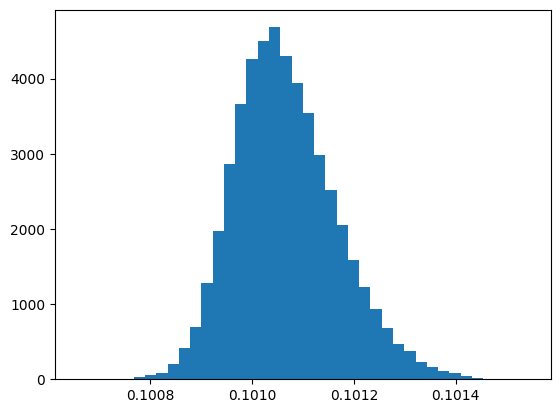

In [ ]:
print(np.sum(all_conf_in>config['resnet']['threshold']))
plt.hist(all_conf_in, bins = 40)
plt.show()

In [ ]:
all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(resnet, cifar10_odin_monitor, 'CIFAR10', 50000)

45578


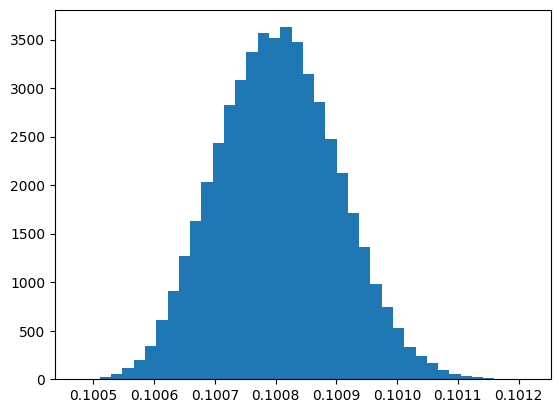

In [ ]:
print(np.sum(all_conf_out<=config['resnet']['threshold']))
plt.hist(all_conf_out, bins = 40)
plt.show()

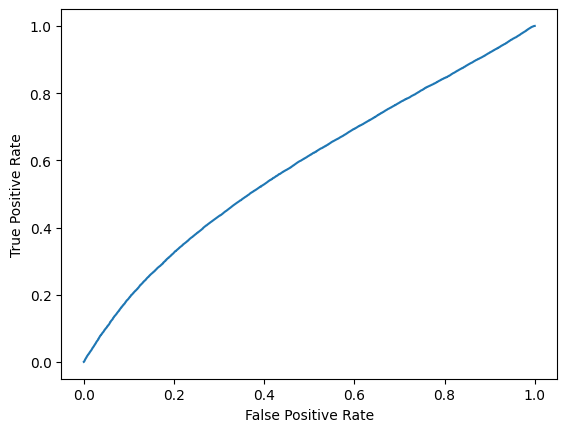

In [ ]:
y_in = np.zeros(all_conf_in.shape)
y_out = np.ones(all_conf_out.shape)
all_conf = np.concatenate((all_conf_in, all_conf_out), axis=None)
y = np.concatenate((y_in, y_out), axis=None)
fpr_list, tpr_list, thresholds = roc_curve(y_true = y, y_score = all_conf)

plot_roc_curve(y, all_conf)

## Monitor evaluation

ResNet

In [12]:
results_resnet = {}
resnet_odin_monitor = OdinMonitor(config['resnet']['temperature'], config['resnet']['noise'], 'cifar10')
resnet_odin_monitor = OdinMonitor(1.0, 0.0, 'cifar10')

In [17]:
results_resnet['in'] = evaluate_ood(resnet, resnet_odin_monitor, 'CIFAR10', True)
results_resnet['out_cifar100'] = evaluate_ood(resnet, resnet_odin_monitor, 'CIFAR100')
results_resnet['out_image_net'] = evaluate_ood(resnet, resnet_odin_monitor, 'IMAGENET')
results_resnet['out_svhn'] = evaluate_ood(resnet, resnet_odin_monitor, 'SVHN')

Accuracy: 99.99800109863281
Files already downloaded and verified
Accuracy: 1.0499999523162842
Accuracy: 11.279999732971191
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 10.44483757019043


In [ ]:
result1 = compute_all_metrics(results_resnet['in'], results_resnet['out_cifar100'], config['resnet']['threshold'])
result2 = compute_all_metrics(results_resnet['in'], results_resnet['out_image_net'], config['resnet']['threshold'])
result3 = compute_all_metrics(results_resnet['in'], results_resnet['out_svhn'], config['resnet']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string +='$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$70.53$ & $89.84$ & $74.89$ & $8663$ & $1337$ & $5261$ & $4739$ & 
$88.46$ & $68.53$ & $90.95$ & $8663$ & $1337$ & $2175$ & $7825$ & 
$82.73$ & $73.84$ & $92.98$ & $8663$ & $1337$ & $9017$ & $17015$ & 


In [ ]:
import numpy as np
def compute_what_i_need(string_in):
  string_in = string_in.replace("$","")
  string_in = string_in.replace(" ","")
  tn, fp, fn, tp = string_in.split('&')
  tn = int(tn)
  fp = int(fp)
  fn = int(fn)
  tp = int(tp)
  tpr = -1
  tnr = -1
  if (tp+fn)>0:
    tpr = np.round(100 * tp/(tp+fn), 2)
  if (tn+fp) > 0:
    tnr = np.round(100 * tn/(tn+fp), 2)
  acc = np.round(100*(tn + tp)/(tn+tp+fn+fp), 2)
  print('$'+str(tpr)+'$' + ' & ' + '$'+str(tnr)+'$' + ' & ' + '$'+str(acc)+'$')

Cifar10AnnModel

In [ ]:
results_cifar10 = {}
cifar10t_odin_monitor = OdinMonitor(config['cifar10']['temperature'], config['cifar10']['noise'], 'cifar10')

In [ ]:
results_cifar10['in'] = evaluate_ood(cifar10_model, cifar10t_odin_monitor, 'CIFAR10')
results_cifar10['out_cifar100'] = evaluate_ood(cifar10_model, cifar10t_odin_monitor, 'CIFAR100')
results_cifar10['out_image_net'] = evaluate_ood(cifar10_model, cifar10t_odin_monitor, 'IMAGENET')
results_cifar10['out_svhn'] = evaluate_ood(cifar10_model, cifar10t_odin_monitor, 'SVHN')

Accuracy: 69.9000015258789
Files already downloaded and verified
Accuracy: 0.9399999976158142
Accuracy: 6.940000057220459
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 11.359999656677246


In [ ]:
result1 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_cifar100'], config['cifar10']['threshold'])
result2 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_image_net'], config['cifar10']['threshold'])
result3 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_svhn'], config['cifar10']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$69.54$ & $75.08$ & $65.87$ & $3735$ & $6265$ & $1178$ & $8822$ & 
$65.97$ & $88.42$ & $64.89$ & $3735$ & $6265$ & $1830$ & $8170$ & 
$73.29$ & $64.27$ & $84.28$ & $3735$ & $6265$ & $1512$ & $24520$ & 


GtsrbAnnModel

In [ ]:
results_gtsrb = {}
gtsrb_odin_monitor = OdinMonitor(config['gtsrb']['temperature'], config['gtsrb']['noise'], 'gtsrb')

In [ ]:
results_gtsrb['in'] = evaluate_ood(gtsrb_model, gtsrb_odin_monitor, 'GTSRB')
results_gtsrb['out_cifar100'] = evaluate_ood(gtsrb_model, gtsrb_odin_monitor, 'CIFAR100')
results_gtsrb['out_image_net'] = evaluate_ood(gtsrb_model, gtsrb_odin_monitor, 'IMAGENET')
results_gtsrb['out_svhn'] = evaluate_ood(gtsrb_model, gtsrb_odin_monitor, 'SVHN')

Accuracy: 87.33000183105469
Files already downloaded and verified
Accuracy: 0.8299999833106995
Accuracy: 0.0
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 1.6100000143051147


In [ ]:
result1 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_cifar100'], config['gtsrb']['threshold'])
result2 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_image_net'], config['gtsrb']['threshold'])
result3 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_svhn'], config['gtsrb']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$95.83$ & $16.97$ & $93.93$ & $11363$ & $1267$ & $1056$ & $8944$ & 
$96.16$ & $15.9$ & $94.41$ & $11363$ & $1267$ & $984$ & $9016$ & 
$95.88$ & $15.29$ & $97.26$ & $11363$ & $1267$ & $2627$ & $23405$ & 
